In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

sys.path.append('src')
from ocr.normalization import word_normalization, letter_normalization
from ocr import page, words
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

### Global Variables

In [3]:
IMG = 'data/pages/try_13.jpg'    # 1, 2, 3
LANG = 'en'
MODEL_LOC_CTC = 'models/word-clas/CTC/Classifier1-17000'

## Load Trained Model

In [4]:
CTC_MODEL = Model(MODEL_LOC_CTC, 'word_prediction')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/word-clas/CTC/Classifier1-17000


## Load Image

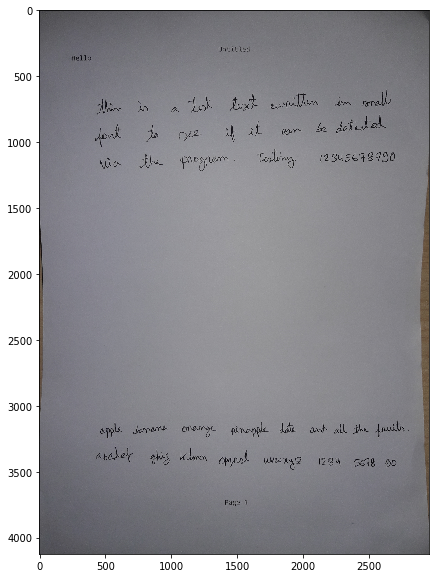

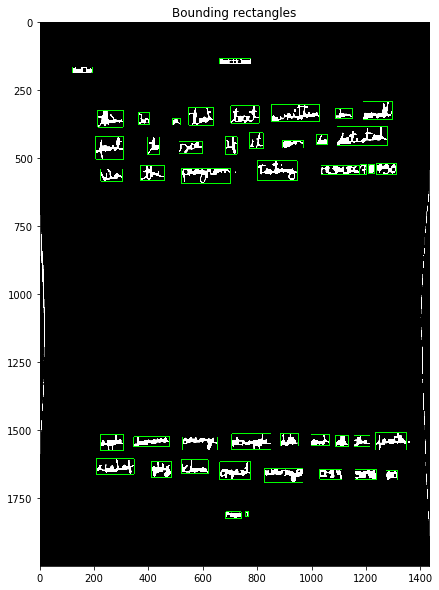

In [5]:
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
boxes = words.detection(crop)
lines = words.sort_words(boxes)

# Recognition Using CTC Model

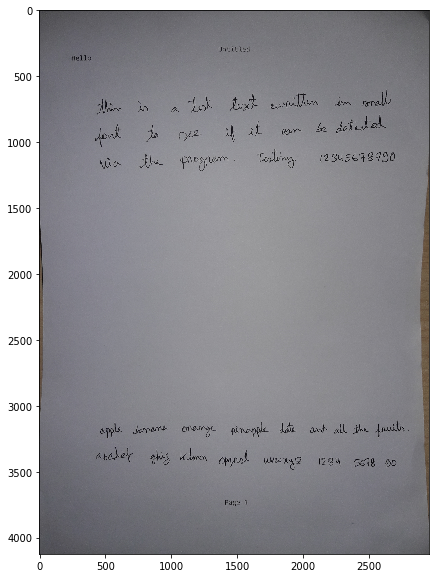

He110 Untitled
thim is lrst lest curitten irn somall
a detected
font te gee it it con be
nia the pregporn Testing 123456 I 8 790
apple banone onange pinapple date and all the frunts
abetet ghing Kehmn oganst wersy 1234 5678 so
pa8e I


In [6]:
def recognise(img):
    """Recognising words using CTC Model."""
    img = word_normalization(
        img,
        64,
        border=False,
        tilt=False,
        hyst_norm=False)
    length = img.shape[1]
    # Input has shape [batch_size, height, width, 1]
    input_imgs = np.zeros(
            (1, 64, length, 1), dtype=np.uint8)
    input_imgs[0][:, :length, 0] = img

    pred = CTC_MODEL.eval_feed({
        'inputs:0': input_imgs,
        'inputs_length:0': [length],
        'keep_prob:0': 1})[0]

    word = ''
    for i in pred:
        word += idx2char(i)
    return word

implt(crop)
for line in lines:
    print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))